In [1]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from meep_material import lorentzfit
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import math
import os
import sys

In [317]:
def Material_fit(Material_data_csv=".",
                 eps_inf_min=1.1, eps_inf_max=1.2, eps_inf_linespace=1,
                 wl_min=0.39, wl_max=0.71,
                 num_L=2, num_rep=100):
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(Material_data_csv)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf_best, suscepts = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf_best, suscepts

    # --- 2) CSV 로드 및 준비 ---
    data      = np.genfromtxt(Material_data_csv, delimiter=",")
    wl        = data[:, 0]                    # 파장 (μm)
    eps_total = data[:, 1] + 1j*data[:, 2]     # permittivity

    mask     = (wl >= wl_min) & (wl <= wl_max)
    wl_red   = wl[mask]
    freqs_red = 1.0 / wl_red
    eps_total_red = eps_total[mask]
    eps_fit_target_raw = eps_total_red        # eps_inf 뺄 전 원본

    # --- 3) 내부 피팅 함수 ---
    def fit_for_eps_inf(eps_inf):
        eps_fit_target = eps_fit_target_raw - eps_inf
        best_err = np.inf
        best_p   = None
        for _ in range(num_rep):
            p0 = []
            for _ in range(num_L):
                # 초기 파라미터: σ∈[1,100], ω∈[1/λ_max,1/λ_min], γ∈[1e-2,1]
                sigma0 = 10**np.random.uniform(0, 2)
                omega0 = np.random.uniform(1.0/wl_max, 1.0/wl_min)
                gamma0 = 10**np.random.uniform(-2, 0)
                p0.extend([sigma0, omega0, gamma0])
            p_opt, err = lorentzfit(p0, freqs_red, eps_fit_target,
                                    nlopt.LD_MMA, 1e-25, 200000)
            if err < best_err:
                best_err = err
                best_p   = p_opt
        return best_err, best_p

    # --- 4) eps_inf 스윕 및 최적화 ---
    eps_inf_vals = np.linspace(eps_inf_min, eps_inf_max, eps_inf_linespace)
    results = []
    for e_inf in eps_inf_vals:
        err, p_opt = fit_for_eps_inf(e_inf)
        results.append((e_inf, err, p_opt))

    eps_inf_best, err_best, p_opt_best = min(results, key=lambda x: x[1])
    print("Best eps_inf:", eps_inf_best, "error:", err_best)

    # --- 5) susceptibilities 생성 ---
    suscepts = []
    for j in range(num_L):
        ω = p_opt_best[3*j + 1]
        γ = p_opt_best[3*j + 2]
        if abs(ω) < 1e-8:
            σ = p_opt_best[3*j + 0]
            suscepts.append(mp.DrudeSusceptibility(frequency=1.0, gamma=γ, sigma=σ))
        else:
            σ = p_opt_best[3*j + 0] / ω**2
            suscepts.append(mp.LorentzianSusceptibility(frequency=ω, gamma=γ, sigma=σ))

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf_best, suscepts), f)
    print(f"Saved fit to pickle: {pickle_path}")

    return eps_inf_best, suscepts

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data_fit.pkl


In [ ]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.399, 0.701],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # nm
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data.csv"

eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path)
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path)

[ 0] RMS error: 6.638814e+04 — params: [2.16890680e+02 9.55233007e+00 2.07723258e+00 1.16347802e-02
 4.36196285e-02 2.28352585e-03 7.21214187e+01 8.22661651e+00
 2.90781830e-01]
[ 1] RMS error: 6.638814e+04 — params: [7.21214111e+01 8.22661651e+00 2.90781796e-01 2.16890695e+02
 9.55232992e+00 2.07723262e+00 1.16347802e-02 4.36196285e-02
 2.28352587e-03]
[ 2] RMS error: 6.638814e+04 — params: [1.16347802e-02 4.36196285e-02 2.28352582e-03 7.21214201e+01
 8.22661651e+00 2.90781835e-01 2.16890675e+02 9.55233005e+00
 2.07723263e+00]
[ 3] RMS error: 6.639700e+04 — params: [1.16313431e-02 4.36198151e-02 2.28312142e-03 2.08050261e+02
 9.57702246e+00 1.99154623e+00 7.74882896e+01 8.22553810e+00
 3.09881270e-01]
[ 4] RMS error: 6.639712e+04 — params: [1.16313211e-02 4.36198162e-02 2.28311886e-03 7.75237095e+01
 8.22553147e+00 3.10008726e-01 2.07991022e+02 9.57716149e+00
 1.99096331e+00]
[ 5] RMS error: 6.841418e+04 — params: [1.77985460e+02 8.88949143e+00 7.71791657e+01 1.15725599e+02
 8.2459131

/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/Sangbin_code/Min code/meep_material.py:20: RuntimeWarning: invalid value encountered in divide
  y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)  # Lorentzian 함수 계산
/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/Sangbin_code/Min code/meep_material.py:34: RuntimeWarning: invalid value encountered in divide
  d = 1 / (np.square(x_n) - np.square(x) - 1j * x * g_n)  # Lorentzian 함수의 도함수


[ 7] RMS error: 9.293596e+04 — params: [111.79339817   8.24591018   0.45861046   0.           3.1440648
   2.11086741  46.59331542   1.79454205 136.33118884]
[ 8] RMS error: 6.639709e+04 — params: [1.16313257e-02 4.36198160e-02 2.28311939e-03 2.08003139e+02
 9.57713293e+00 1.99108242e+00 7.75164532e+01 8.22553282e+00
 3.09982619e-01]
[ 9] RMS error: 6.638814e+04 — params: [1.16347803e-02 4.36196285e-02 2.28352586e-03 7.21214216e+01
 8.22661651e+00 2.90781830e-01 2.16890644e+02 9.55232987e+00
 2.07723217e+00]
[10] RMS error: 6.892296e+04 — params: [1.14676815e-02 4.36290045e-02 2.26343948e-03 6.41610139e-19
 2.04464045e+00 3.98372704e+00 1.39861933e+02 8.25107658e+00
 5.99514754e-01]
[11] RMS error: 6.884323e+04 — params: [1.16912568e+01 4.78969368e+00 1.23503220e+00 1.15165043e-02
 4.36261926e-02 2.26937451e-03 1.32641432e+02 8.24980253e+00
 5.61157538e-01]
[12] RMS error: 6.639700e+04 — params: [2.08049888e+02 9.57702289e+00 1.99154240e+00 7.74884791e+01
 8.22553806e+00 3.09881962e-01

In [429]:
### ----- Refractive index ----- ###,
sio2 =  mp.Medium(epsilon = eps_inf_sio2,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = eps_inf_andp,   E_susceptibilities = suscept_andp, valid_freq_range=freq_andp) # aNDP ,
Al  =   mp.Medium(epsilon = eps_inf_al,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)
Air =   mp.Medium(index = 1)

In [430]:
resolution = 1000 # 해상도
design_region_x = 0.01 # 디자인 영역 x
design_region_y = 0.01 # 디자인 영역 y
design_region_z = 2 # 디자인 영역 높이 z
pml_size = 1.0 # PML 영역 크기

In [431]:
# 시뮬레이션 공간 설정
Sx = design_region_x
Sy = design_region_y
Sz = 2 * pml_size + design_region_z + 1 + 5
cell_size = mp.Vector3(0, 0, Sz)

In [432]:
from pathlib import Path

al_csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data.csv")
sio2_csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv")
andp_csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data.csv")

# Wavelength data
sio2_data = np.genfromtxt(sio2_csv_path, delimiter=",")
andp_data = np.genfromtxt(andp_csv_path, delimiter=",")
al_data = np.genfromtxt(al_csv_path, delimiter=",")

sio2_wavelengths = sio2_data[:,0]
andp_wavelengths = andp_data[:,0]
al_wavelengths = al_data[:,0]

sio2_frequencies = 1 / sio2_wavelengths
andp_frequencies = 1 / andp_wavelengths
al_frequencies = 1 / al_wavelengths

nf_sio2 = len(sio2_frequencies)
nf_andp = len(andp_frequencies)
nf_al = len(al_frequencies)

In [433]:
minimum_length = 0.05  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(thickness = pml_size, direction = mp.Z)]

In [434]:
materials = {
    'al':   {'wavelengths': al_data[:,0],   'frequencies': 1 / al_data[:,0]},
    'sio2': {'wavelengths': sio2_data[:,0], 'frequencies': 1 / sio2_data[:,0]},
    'andp': {'wavelengths': andp_data[:,0], 'frequencies': 1 / andp_data[:,0]},
}

# --- 2) 색상별 파장 범위 정의 ---
wl_ranges = {
    'blue':  (0.4, 0.50),
    'green': (0.50, 0.60),
    'red':   (0.60, 0.7),
}

width = 0.1  # fwidth 계산용 계수

# --- 3) 재료별로 색상별 freqs/fwidths 및 총 필터된 포인트 계산 ---
results = {}

for mat, data in materials.items():
    wl = data['wavelengths']
    fr = data['frequencies']
    total_count = 0
    freqs_color = {}
    fwidths_color = {}
    for color, (wl_min, wl_max) in wl_ranges.items():
        mask = (wl >= wl_min) & (wl <= wl_max)
        freqs_color[color] = fr[mask]
        fwidths_color[color] = width * fr[mask]
        total_count += np.count_nonzero(mask)
    results[mat] = {
        'freqs': freqs_color,
        'fwidths': fwidths_color,
        'total_filtered_points': total_count
    }

# --- 4) 결과 출력 ---
for mat, data in results.items():
    print(f"\n== {mat.upper()} ==")
    for color in wl_ranges:
        print(f"{color.title():6s} frequencies:", data['freqs'][color])
        print(f"{color.title():6s} fwidths:   ", data['fwidths'][color])
    print(f"Total filtered points: {data['total_filtered_points']}")


== AL ==
Blue   frequencies: [2.         2.01653559 2.09687566 2.17770035 2.22222222 2.25835592
 2.33918129 2.41954996 2.5       ]
Blue   fwidths:    [0.2        0.20165356 0.20968757 0.21777003 0.22222222 0.22583559
 0.23391813 0.241955   0.25      ]
Green  frequencies: [1.66666667 1.69376694 1.73400381 1.77430802 1.81488203 1.81818182
 1.85494342 1.89537528 1.93573364 1.97589409 2.        ]
Green  fwidths:    [0.16666667 0.16937669 0.17340038 0.1774308  0.1814882  0.18181818
 0.18549434 0.18953753 0.19357336 0.19758941 0.2       ]
Red    frequencies: [1.42857143 1.45180023 1.49209191 1.53233221 1.53846154 1.57282164
 1.61316341 1.65343915 1.66666667]
Red    fwidths:    [0.14285714 0.14518002 0.14920919 0.15323322 0.15384615 0.15728216
 0.16131634 0.16534392 0.16666667]
Total filtered points: 29

== SIO2 ==
Blue   frequencies: [2.05705023 2.13759256 2.29444629 2.47123483]
Blue   fwidths:    [0.20570502 0.21375926 0.22944463 0.24712348]
Green  frequencies: [1.69703799 1.70195095 1.726

In [435]:
# al - frequency, fwidth 결과 슬라이싱  
al_red_freqs = results['al']['freqs']['red']
al_green_freqs = results['al']['freqs']['green']
al_blue_freqs = results['al']['freqs']['blue']

al_red_fwidths = results['al']['fwidths']['red']
al_green_fwidths = results['al']['fwidths']['green']
al_blue_fwidths = results['al']['fwidths']['blue']

# aNDP - frequency, fwidth 결과 슬라이싱  
andp_red_freqs = results['andp']['freqs']['red']
andp_green_freqs = results['andp']['freqs']['green']
andp_blue_freqs = results['andp']['freqs']['blue']

andp_red_fwidths = results['andp']['fwidths']['red']
andp_green_fwidths = results['andp']['fwidths']['green']
andp_blue_fwidths = results['andp']['fwidths']['blue']

# sio2 - frequency, fwidth 결과 슬라이싱  
sio2_red_freqs = results['sio2']['freqs']['red']
sio2_green_freqs = results['sio2']['freqs']['green']
sio2_blue_freqs = results['sio2']['freqs']['blue']

sio2_red_fwidths = results['sio2']['fwidths']['red']
sio2_green_fwidths = results['sio2']['fwidths']['green']
sio2_blue_fwidths = results['sio2']['fwidths']['blue']

In [436]:
source_center = [0, 0, Sz / 2 - pml_size] # Source 위치

src_0 = mp.GaussianSource(frequency=sio2_red_freqs[1], fwidth=sio2_red_fwidths[1], is_integrated=True)

source = [mp.Source(src_0, component=mp.Ey, center=source_center)]

In [437]:
Nx = int(round(design_region_resolution * design_region_x)) + 1
Ny = int(round(design_region_resolution * design_region_y)) + 1
Nz = int(round(design_region_resolution * design_region_z)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(0, 0, Nz), Air, sio2, grid_type="U_MEAN")

In [438]:
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - pml_size - 2),
        size=mp.Vector3(design_region_x, design_region_y, design_region_z),
    ),
)

In [439]:
geometry = [
    mp.Block(
        center=design_region.center, size=mp.Vector3(mp.inf, mp.inf, 0.2), material=sio2
    )
]

In [440]:
sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    extra_materials=[sio2],
    k_point = mp.Vector3(0,0,0),
    dimensions=1
)

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-Sx/2 + 1, Sy/2  - 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-Sx/2 + 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(Sx/2 - 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(Sx/2 - 1, Sy/2  -  1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함
FourierFields_0 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_1 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_2 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_3 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_4 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_5 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_6 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_7 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_8 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_9 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_10 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_11 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
ob_list = [FourierFields_0, FourierFields_1, FourierFields_2,FourierFields_3, FourierFields_4, FourierFields_5 ,FourierFields_6, FourierFields_7, FourierFields_8,FourierFields_9, FourierFields_10, FourierFields_11]

# In[16]:


# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 Ez 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
def J_0(fields_0, fields_1, fields_2,fields_3, fields_4, fields_5,fields_6, fields_7, fields_8,fields_9, fields_10, fields_11):
    return npa.mean(npa.abs(fields_0[6,:]) ** 2) + npa.mean(npa.abs(fields_1[7,:]) ** 2) + npa.mean(npa.abs(fields_2[8,:]) ** 2) + npa.mean(npa.abs(fields_3[3,:]) ** 2) + npa.mean(npa.abs(fields_4[4,:]) ** 2) + npa.mean(npa.abs(fields_5[5,:]) ** 2) + npa.mean(npa.abs(fields_6[0,:]) ** 2) + npa.mean(npa.abs(fields_7[1,:]) ** 2) + npa.mean(npa.abs(fields_8[2,:]) ** 2) + npa.mean(npa.abs(fields_9[3,:]) ** 2) + npa.mean(npa.abs(fields_10[4,:]) ** 2) + npa.mean(npa.abs(fields_11[5,:]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=al_green_freqs,
    decay_by=1e-9
)


In [441]:
opt.sim.reset_meep()
#simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(mp.inf, mp.inf, 0), material=Air
    )
]

In [442]:
opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[sio2],
    k_point = mp.Vector3(0,0,0),
    dimensions=1
)
fcen = (1/(0.40 ) + 1/(0.70 ))/2
df = 1 /(0.40  ) - 1/(0.70  )
nfreq = 100

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ex, center=source_center)]
opt.sim.change_sources(source)


In [443]:
#reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - pml_size - 0.3)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

#transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)


#pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)


#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

opt.sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9))

#데이터 저장

straight_refl_data = opt.sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000216007 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 1000
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00118995 s
lorentzian susceptibility: frequency=8.22662, gamma=0.290782
lorentzian susceptibility: frequency=0.0436196, gamma=0.00228353
lorentzian susceptibility: frequency=9.55233, gamma=2.07723
-----------
run 0 finished at t = 17.6225 (35245 timesteps)


In [444]:
opt.sim.reset_meep()

#simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[sio2],
    k_point = mp.Vector3(0,0,0),
    dimensions=1
)

fcen = (1/(0.40) + 1/(0.70))/2
df = 1 /(0.40) - 1/(0.70)

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ex, center=source_center)]
opt.sim.change_sources(source)

In [445]:
# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)
)
tran = opt.sim.add_flux(fcen, df, nfreq, tran_fr)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

opt.sim.load_minus_flux_data(refl, straight_refl_data)

#각각 픽셀의 flux 구하기

# tran_r = mp.FluxRegion(
#     center=mp.Vector3(-Sx/2 + 1, Sy/2  - 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_g = mp.FluxRegion(
#     center=mp.Vector3(-Sx/2 + 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_b = mp.FluxRegion(
#     center=mp.Vector3(Sx/2 - 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_g0 = mp.FluxRegion(
#     center=mp.Vector3(Sx/2 - 1, Sy/2  -  1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )

# tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
# tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
# tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
# tran_green0 = opt.sim.add_flux(fcen, df, nfreq, tran_g0)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000209093 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 1000
     block, center = (0,0,2)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.00137806 s
lorentzian susceptibility: frequency=8.22662, gamma=0.290782
lorentzian susceptibility: frequency=0.0436196, gamma=0.00228353
lorentzian susceptibility: frequency=9.55233, gamma=2.07723
-----------


In [446]:
pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-9))

#데이터 저장

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

# red_flux = mp.get_fluxes(tran_red)
# green_flux = mp.get_fluxes(tran_green)
# blue_flux = mp.get_fluxes(tran_blue)
# green_flux0 = mp.get_fluxes(tran_green0)

run 0 finished at t = 18.023 (36046 timesteps)


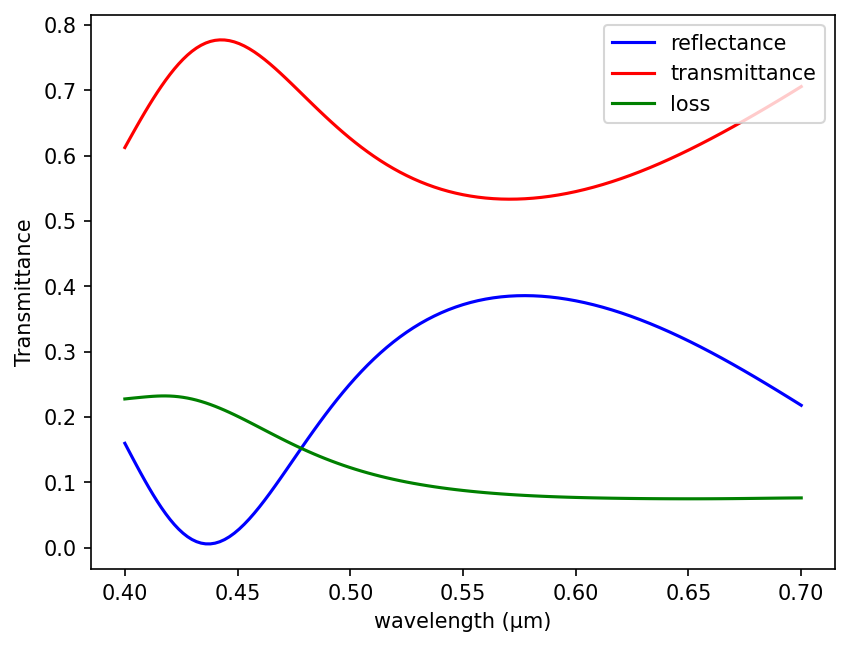

In [447]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] ))
    Rs = np.append(Rs, -bend_refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig("Resolution1000.png")